**IMPORT LIBRRARIES**

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Input, Layer, InputSpec

from keras import regularizers, activations, initializers,constraints, Sequential
from keras import backend as K
from keras.constraints import UnitNorm, Constraint

**DATA PREPROCESSING**

In [2]:
# mount drive to load large dataset directly from it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load data and check dimensions
train = pd.read_csv('drive/My Drive/Deep Learning/mnist-fashion/fashion-mnist_train.csv')
test = pd.read_csv('drive/My Drive/Deep Learning/mnist-fashion/fashion-mnist_test.csv')
print(train.shape)
print(test.shape)

# remove extra column
train = np.array(train)[:,1:]
test = np.array(test)[:,1:]
print('Dimension of train data:',train.shape)
print('Dimension of test data:',test.shape)

(60000, 785)
(10000, 785)
Dimension of train data: (60000, 784)
Dimension of test data: (10000, 784)


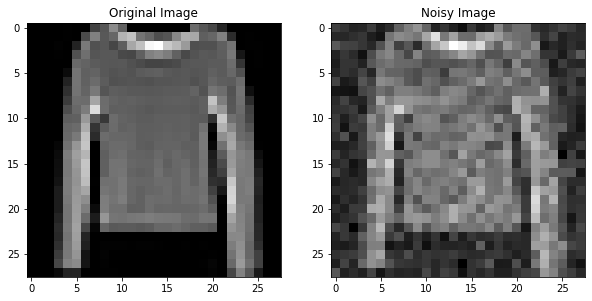

In [4]:
# add noise to data
noisy_train = train + np.random.normal(0, 25, size = train.shape)
noisy_test = test + np.random.normal(0, 25, size = test.shape)

# view sample image from data
sample_ind = 120
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.reshape(train[sample_ind],(28,28)), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(np.reshape(noisy_train[sample_ind],(28,28)), cmap='gray')
plt.title('Noisy Image')
plt.show()

In [5]:
# normalise the data
train = train/255.0
test = test/255.0
noisy_train = noisy_train/255.0
noisy_train = np.clip(noisy_train, 0, 1)
noisy_test = noisy_test/255.0
noisy_test = np.clip(noisy_test, 0, 1)

**UTILITY FUNCTIONS**

In [16]:
# function to create result subplots
def plots(grid_row, grid_col, images, headings):
  plt.figure(figsize=(15,12))
  for i in range(len(images)):   
    plt.subplot(grid_row, grid_col, i+1)
    plt.imshow(np.reshape(images[i],(28,28)),cmap='gray')
    plt.title(headings[i])
  plt.show()

In [17]:
# function for custom weight tying 
# Source: https://towardsdatascience.com/build-the-right-autoencoder-tune-and-optimize-using-pca-principles-part-ii-24b9cca69bd6

class DenseTranspose(Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True
                
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

**BUILD MODEL**

In [18]:
# Input parameters: 

# input dimension (number of features)
# hidden and output layer dimensions
# activation at each layer
# weight initialisation 
# weight regularisation
# optimiser
# epochs
# batch size
# original train data
# noisy train data

def build(dims, act, input_dim = 784, w_ini = 'glorot_uniform', w_reg = None, opt = 'adam', epoch = 50, batch_size = 2048, x = noisy_train, y = train):
  
  model = Sequential()
  model.add(keras.Input(shape=(input_dim,)))

  for i in range(len(dims)-1):
    
    model.add(Dense(dims[i], act[i], 1, w_ini, w_reg))

  model.add(Dense(dims[-1], act[-1], 1, w_ini))
  model.compile(loss='mse', optimizer=opt, metrics=['mse'])

  history = model.fit(x, y, epochs=epoch, batch_size=batch_size, verbose=0)

  return model, history

In [23]:
# model with tied weights (same parameters as above)

def build_WT(dims, act, input_dim = 784, w_ini = 'glorot_uniform', w_reg = None, opt = 'adam', epoch = 50, batch_size = 2048, x = noisy_train, y = train):

  model = Sequential()
  encoder = Dense(dims[0], input_dim = input_dim, activation = act[0])
  model.add(encoder)

  for i in range(1, len(dims)-1):
    model.add(Dense(dims[i], activation = act[i]))

  decoder = DenseTranspose(dims[-1], activation = act[-1], tied_to = encoder)
  model.add(decoder)

  model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])

  history = model.fit(noisy_train, train, epochs = epoch, verbose = 0, batch_size = batch_size) 

  return model, history

# UNDERCOMPLETE

**EFFECT OF NUMBER OF HIDDEN LAYERS**

In [ ]:
# 3 layers
dims = [256,64,256,784]
act = ['relu'] * len(dims)
model1, hist1 = build(dims, act)

# 4 layers
dims = [256,64,64,256,784]
act = ['relu'] * len(dims)
model2, hist2 = build(dims, act)

# 5 layers
dims = [256,64,32,64,256,784]
act = ['relu'] * len(dims)
model3, hist3 = build(dims, act)

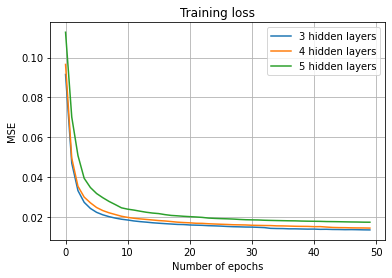

In [ ]:
plt.plot(hist1.history['mse'], label = '3 hidden layers')
plt.plot(hist2.history['mse'], label = '4 hidden layers')
plt.plot(hist3.history['mse'], label = '5 hidden layers')
plt.title('Training loss')
plt.ylabel('MSE')
plt.xlabel('Number of epochs')
plt.legend()
plt.grid()
plt.show()

**Observation** <br>
The training MSE decreases with epochs. The results are comparable for any number of hidden layers, although the MSE is slightly higher for more hidden layers, possibly due overfitting.



In [ ]:
result1 = model1.predict(test)
result2 = model2.predict(test)
result3 = model3.predict(test)

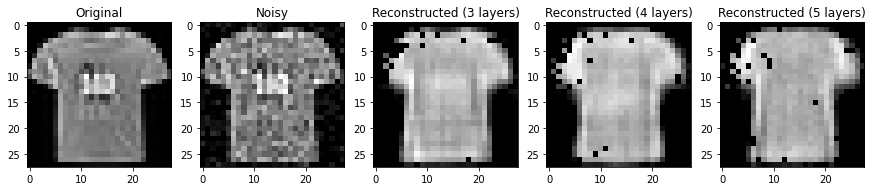

In [ ]:
images = [test[sample_ind], noisy_test[sample_ind], result1[sample_ind]*255, result2[sample_ind]*255, result3[sample_ind]*255]
headings = ['Original','Noisy','Reconstructed (3 layers)','Reconstructed (4 layers)','Reconstructed (5 layers)']
plots(1, 5, images, headings)

**Observation** <br>
Since the training MSEs are almost same, the reconstructed images are comparable for any number of hidden layers.

**EFFECT OF WEIGHT INITIALISATION**

In [60]:
dims = [256,64,256,784]
act = ['relu'] * len(dims)

# glorot uniform
model1, hist1 = build(dims, act, w_ini = 'glorot_uniform')

# glorot normal
model2, hist2 = build(dims, act, w_ini = 'glorot_normal')

# random uniform
model3, hist3 = build(dims, act, w_ini = 'random_uniform')

# random normal
model4, hist4 = build(dims, act, w_ini = 'random_normal')

# He normal
model5, hist5 = build(dims, act, w_ini = 'he_normal')

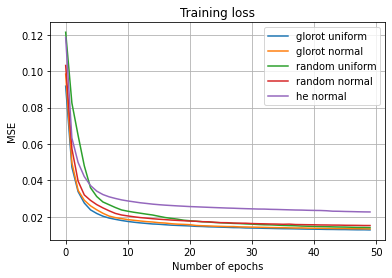

In [66]:
plt.plot(hist1.history['mse'], label = 'glorot uniform')
plt.plot(hist2.history['mse'], label = 'glorot normal')
plt.plot(hist3.history['mse'], label = 'random uniform')
plt.plot(hist4.history['mse'], label = 'random normal')
plt.plot(hist5.history['mse'], label = 'he normal')
plt.title('Training loss')
plt.ylabel('MSE')
plt.xlabel('Number of epochs')
plt.legend()
plt.grid()
plt.show()

**Observation** <br>
The training MSE decreases with epochs. The results are almost comparable for any weight initialisation, with the MSE of He normal being slightly higher than others.

In [62]:
result1 = model1.predict(test)
result2 = model2.predict(test)
result3 = model3.predict(test)
result4 = model4.predict(test)
result5 = model5.predict(test)

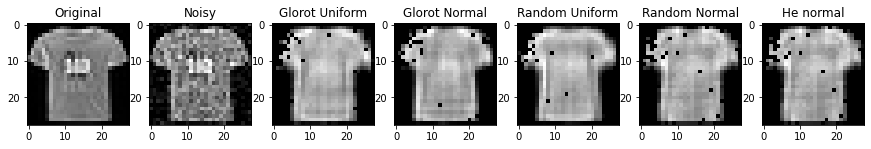

In [64]:
images = [test[sample_ind], noisy_test[sample_ind], result1[sample_ind]*255, result2[sample_ind]*255, 
          result3[sample_ind]*255, result4[sample_ind]*255, result4[sample_ind]*255]
headings = ['Original','Noisy','Glorot Uniform', 'Glorot Normal', 
            'Random Uniform', 'Random Normal','He normal']
plots(1, 7, images, headings)

**Observation** <br>
Since the training MSEs are almost same, the reconstructed images are comparable for any weight initialisation.

**EFEFCT OF WEIGHT TYING**

In [29]:
dims = [256,64,256,784]
act = ['relu'] * len(dims)

# weight tying
start = time.time()
model1, hist1 = build_WT(dims, act) 
end = time.time()

print('With weight tying: Final MSE is {}'.format(hist1.history['mse'][-1]))
print('Training time is {}s'.format(end-start))

# no weight tying
start = time.time()
model2, hist2 = build(dims, act)
end = time.time()

print('Without weight tying: Final MSE is {}'.format(hist2.history['mse'][-1]))
print('Training time is {}s'.format(end-start))

With weight tying: Final MSE is 0.06256149709224701
Training time is 112.54643249511719s
Without weight tying: Final MSE is 0.013701256364583969
Training time is 131.38296461105347s


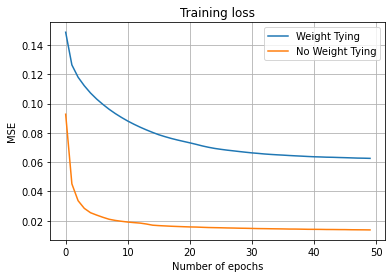

In [25]:
plt.plot(hist1.history['mse'], label = 'Weight Tying')
plt.plot(hist2.history['mse'], label = 'No Weight Tying')
plt.title('Training loss')
plt.ylabel('MSE')
plt.xlabel('Number of epochs')
plt.legend()
plt.grid()
plt.show()

**Observation** <br>
The training MSE decreases with epochs. With weigth tying, the number of trainable parameters are reduced so the MSE is higher than that of the model without weight tying. This is a tradeoff with the higher training speed with weight tying.

In [26]:
result1 = model1.predict(test)
result2 = model2.predict(test)

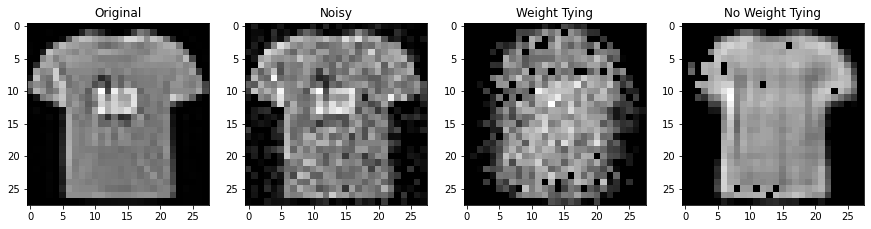

In [27]:
images = [test[sample_ind], noisy_test[sample_ind], result1[sample_ind]*255, result2[sample_ind]*255]
headings = ['Original','Noisy','Weight Tying','No Weight Tying']
plots(1, 4, images, headings)


**Observation** <br>
Since the training MSE is higher with weight tying, the model does not learn a lot parameters and hence the rerconstructed image is distorted as copared to the image reconstructed without tying.

# OVERCOMPLETE

**EFFECT OF NUMBER OF HIDDEN LAYERS**

In [8]:
# 3 layers
dims = [1000, 1200, 1000, 784]
act = ['relu'] * len(dims)
model1, hist1 = build(dims, act)

# 4 layers
dims = [1000, 1200, 1200, 1000, 784]
act = ['relu'] * len(dims)
model2, hist2 = build(dims, act)

# 5 layers
dims = [1000, 1100, 1200, 1100, 1000, 784]
act = ['relu'] * len(dims)
model3, hist3 = build(dims, act)

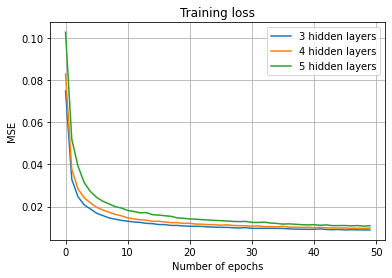

In [9]:
plt.plot(hist1.history['mse'], label = '3 hidden layers')
plt.plot(hist2.history['mse'], label = '4 hidden layers')
plt.plot(hist3.history['mse'], label = '5 hidden layers')
plt.title('Training loss')
plt.ylabel('MSE')
plt.xlabel('Number of epochs')
plt.legend()
plt.grid()
plt.show()

**Observation** <br>
The training MSE decreases with epochs. The results are comparable for any number of hidden layers, although the MSE is slightly higher for more hidden layers, possibly due overfitting.



In [10]:
result1 = model1.predict(test)
result2 = model2.predict(test)
result3 = model3.predict(test)

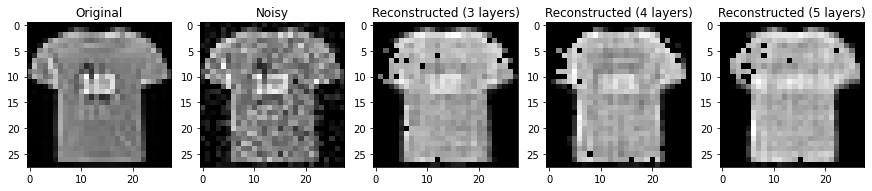

In [11]:
images = [test[sample_ind], noisy_test[sample_ind], result1[sample_ind]*255, result2[sample_ind]*255, result3[sample_ind]*255]
headings = ['Original','Noisy','Reconstructed (3 layers)','Reconstructed (4 layers)','Reconstructed (5 layers)']
plots(1, 5, images, headings)

**Observation** <br>
Since the training MSEs are almost same, the reconstructed images are comparable for any number of hidden layers.

**EFFECT OF WEIGHT INITIALISATION**

In [12]:
dims = [1000, 1200, 1000, 784]
act = ['relu'] * len(dims)

# glorot uniform
model1, hist1 = build(dims, act, w_ini = 'glorot_uniform')

# glorot normal
model2, hist2 = build(dims, act, w_ini = 'glorot_normal')

# random uniform
model3, hist3 = build(dims, act, w_ini = 'random_uniform')

# random normal
model4, hist4 = build(dims, act, w_ini = 'random_normal')

# He normal
model5, hist5 = build(dims, act, w_ini = 'he_normal')

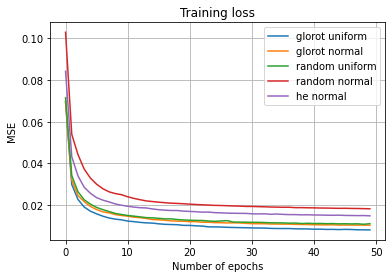

In [13]:
plt.plot(hist1.history['mse'], label = 'glorot uniform')
plt.plot(hist2.history['mse'], label = 'glorot normal')
plt.plot(hist3.history['mse'], label = 'random uniform')
plt.plot(hist4.history['mse'], label = 'random normal')
plt.plot(hist5.history['mse'], label = 'he normal')
plt.title('Training loss')
plt.ylabel('MSE')
plt.xlabel('Number of epochs')
plt.legend()
plt.grid()
plt.show()

**Observation** <br>
The training MSE decreases with epochs. The results are almost comparable for any weight initialisation, with the MSE of random normal being slightly higher than others.

In [14]:
result1 = model1.predict(test)
result2 = model2.predict(test)
result3 = model3.predict(test)
result4 = model4.predict(test)
result5 = model5.predict(test)

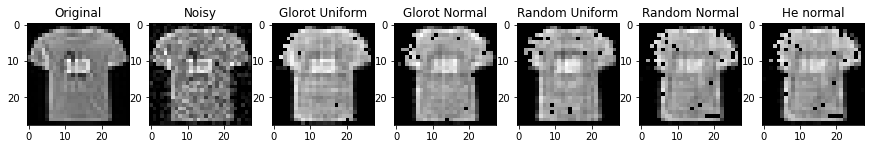

In [15]:
images = [test[sample_ind], noisy_test[sample_ind], result1[sample_ind]*255, result2[sample_ind]*255, 
          result3[sample_ind]*255, result4[sample_ind]*255, result4[sample_ind]*255]
headings = ['Original','Noisy','Glorot Uniform', 'Glorot Normal', 
            'Random Uniform', 'Random Normal','He normal']
plots(1, 7, images, headings)

**Observation** <br>
Since the training MSEs are almost same, the reconstructed images are comparable for any weight initialisation.

**EFEFCT OF WEIGHT TYING**

In [34]:
dims = [1000, 1200, 1000, 784]
act = ['relu'] * len(dims)

# weight tying
start = time.time()
model1, hist1 = build_WT(dims, act) 
end = time.time()

print('With weight tying: Final MSE is {}'.format(hist1.history['mse'][-1]))
print('Training time is {}s'.format(end-start))

# no weight tying
start = time.time()
model2, hist2 = build(dims, act)
end = time.time()

print('Without weight tying: Final MSE is {}'.format(hist2.history['mse'][-1]))
print('Training time is {}s'.format(end-start))

With weight tying: Final MSE is 0.01750875450670719
Training time is 1024.5953288078308s
Without weight tying: Final MSE is 0.007240848615765572
Training time is 1099.2845447063446s


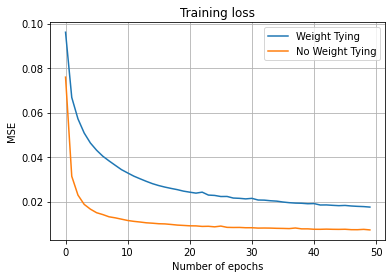

In [31]:
plt.plot(hist1.history['mse'], label = 'Weight Tying')
plt.plot(hist2.history['mse'], label = 'No Weight Tying')
plt.title('Training loss')
plt.ylabel('MSE')
plt.xlabel('Number of epochs')
plt.legend()
plt.grid()
plt.show()

**Observation** <br>
The training MSE decreases with epochs. With weigth tying, the number of trainable parameters are reduced so the MSE is higher than that of the model without weight tying. This is a tradeoff with the higher training speed with weight tying.

In [32]:
result1 = model1.predict(test)
result2 = model2.predict(test)

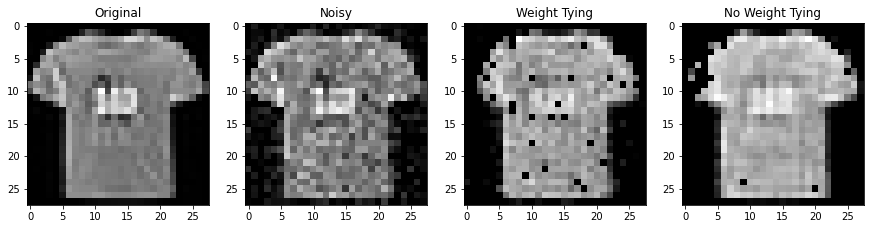

In [33]:
images = [test[sample_ind], noisy_test[sample_ind], result1[sample_ind]*255, result2[sample_ind]*255]
headings = ['Original','Noisy','Weight Tying','No Weight Tying']
plots(1, 4, images, headings)

**Observation** <br>
Since the training MSE is higher with weight tying, the model does not learn a lot parameters and hence the rerconstructed image is distorted as copared to the image reconstructed without tying.